In [186]:
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [187]:
class MyCnn(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCnn, self).__init__()
        self.features = nn.Sequential(
            # kernel_size:畳み込む行列のサイズ
            # stride:スライドするときのサイズ
            # padding:上下左右に追加する空白
            # 1*28*28 のデータ
            nn.Conv2d(1, 64, kernel_size=2, stride=1, padding=1), # 1*28*28 => 64*29*29
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1), #64*29*29 => 64*27*27 46656
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1), # 64*27*27 => 192*27*27 139968
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3), # 192*27*27 => 192*9*9 15552
            nn.Conv2d(192, 384, kernel_size=2, stride=1, padding=1), # 192*9*9 => 384*10*10
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # 384*10*10 => 256*10*10
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # 256*10*10 => 256*10*10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256*10*10 => 256*5*5
        )
            
        self.classifier = nn.Linear(256*5*5, 10)
#         self.classifier = nn.Linear(28*28, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [188]:
def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    return {'train': train_loader, 'test': test_loader}

In [189]:
class ZeroDLCnn(nn.Module):
    def __init__(self, num_classes=10):
        super(ZeroDLCnn, self).__init__()
        self.features = nn.Sequential(
            # kernel_size:畳み込む行列のサイズ
            # stride:スライドするときのサイズ
            # padding:上下左右に追加する空白
            # 1*28*28 のデータ
            nn.Conv2d(1, 30, kernel_size=5, stride=1, padding=0), # 1*28*28 => 30*24*24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #30*24*24 => 30*12*12
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(30*12*12, 30*12*12),
            nn.ReLU(inplace=True),
            nn.Linear(30*12*12, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [193]:
num_epoch = 20
history = {
    'train_loss':[],
    'test_loss':[],
    'test_acc':[]
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ZeroDLCnn().to(device)
loaders = load_MNIST()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

In [194]:
for i_epoch in range(num_epoch):
    loss = None
    
    net.train(True)
    
    criterion = nn.CrossEntropyLoss()
    
    for i, (data, target) in enumerate(loaders['train']):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        
#         print(output.shape)
        
        loss = f.nll_loss(output, target)
#         loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(i_epoch+1, (i+1)*128, loss.item()))
    
    history['train_loss'].append(loss.item())
    
    net.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
#             loss = criterion(output, target)
#             test_loss += loss.item()
            test_loss += f.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= 10000
    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss, correct / 10000))
    
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)

Training log: 1 epoch (128 / 60000 train. data). Loss: -0.10040080547332764
Training log: 1 epoch (1408 / 60000 train. data). Loss: -0.44055724143981934
Training log: 1 epoch (2688 / 60000 train. data). Loss: -0.6125679016113281
Training log: 1 epoch (3968 / 60000 train. data). Loss: -0.6613986492156982
Training log: 1 epoch (5248 / 60000 train. data). Loss: -0.7226717472076416
Training log: 1 epoch (6528 / 60000 train. data). Loss: -0.6618556976318359
Training log: 1 epoch (7808 / 60000 train. data). Loss: -0.6905960440635681
Training log: 1 epoch (9088 / 60000 train. data). Loss: -0.6745857000350952
Training log: 1 epoch (10368 / 60000 train. data). Loss: -0.6474494338035583
Training log: 1 epoch (11648 / 60000 train. data). Loss: -0.634105920791626
Training log: 1 epoch (12928 / 60000 train. data). Loss: -0.6451714634895325
Training log: 1 epoch (14208 / 60000 train. data). Loss: -0.5978111624717712
Training log: 1 epoch (15488 / 60000 train. data). Loss: -0.6618903875350952
Trainin

Training log: 3 epoch (15488 / 60000 train. data). Loss: -0.9895012974739075
Training log: 3 epoch (16768 / 60000 train. data). Loss: -0.976248562335968
Training log: 3 epoch (18048 / 60000 train. data). Loss: -0.9563840627670288
Training log: 3 epoch (19328 / 60000 train. data). Loss: -0.9862301349639893
Training log: 3 epoch (20608 / 60000 train. data). Loss: -0.9844238758087158
Training log: 3 epoch (21888 / 60000 train. data). Loss: -0.9787388443946838
Training log: 3 epoch (23168 / 60000 train. data). Loss: -0.984586238861084
Training log: 3 epoch (24448 / 60000 train. data). Loss: -0.9994561672210693
Training log: 3 epoch (25728 / 60000 train. data). Loss: -0.9999067187309265
Training log: 3 epoch (27008 / 60000 train. data). Loss: -0.9847069978713989
Training log: 3 epoch (28288 / 60000 train. data). Loss: -0.9672856330871582
Training log: 3 epoch (29568 / 60000 train. data). Loss: -0.981871485710144
Training log: 3 epoch (30848 / 60000 train. data). Loss: -0.9572495222091675
Tr

Training log: 5 epoch (30848 / 60000 train. data). Loss: -0.9912493228912354
Training log: 5 epoch (32128 / 60000 train. data). Loss: -0.9998592138290405
Training log: 5 epoch (33408 / 60000 train. data). Loss: -0.9689576029777527
Training log: 5 epoch (34688 / 60000 train. data). Loss: -0.9753574132919312
Training log: 5 epoch (35968 / 60000 train. data). Loss: -0.9993498921394348
Training log: 5 epoch (37248 / 60000 train. data). Loss: -0.9999514222145081
Training log: 5 epoch (38528 / 60000 train. data). Loss: -0.9797213077545166
Training log: 5 epoch (39808 / 60000 train. data). Loss: -0.9779539704322815
Training log: 5 epoch (41088 / 60000 train. data). Loss: -0.9970047473907471
Training log: 5 epoch (42368 / 60000 train. data). Loss: -0.9967511296272278
Training log: 5 epoch (43648 / 60000 train. data). Loss: -0.9890555739402771
Training log: 5 epoch (44928 / 60000 train. data). Loss: -0.9887833595275879
Training log: 5 epoch (46208 / 60000 train. data). Loss: -0.9805943965911865

Training log: 7 epoch (46208 / 60000 train. data). Loss: -0.9865005016326904
Training log: 7 epoch (47488 / 60000 train. data). Loss: -0.9891312718391418
Training log: 7 epoch (48768 / 60000 train. data). Loss: -0.9919866919517517
Training log: 7 epoch (50048 / 60000 train. data). Loss: -0.9977084398269653
Training log: 7 epoch (51328 / 60000 train. data). Loss: -0.9881899356842041
Training log: 7 epoch (52608 / 60000 train. data). Loss: -0.9720696210861206
Training log: 7 epoch (53888 / 60000 train. data). Loss: -0.9830096960067749
Training log: 7 epoch (55168 / 60000 train. data). Loss: -0.9920899271965027
Training log: 7 epoch (56448 / 60000 train. data). Loss: -0.9994844198226929
Training log: 7 epoch (57728 / 60000 train. data). Loss: -0.9929376840591431
Training log: 7 epoch (59008 / 60000 train. data). Loss: -0.9921717643737793
Test loss (avg): -0.9861274024963379, Accuracy: 0.9865
Training log: 8 epoch (128 / 60000 train. data). Loss: -0.9921848773956299
Training log: 8 epoch (

Training log: 10 epoch (1408 / 60000 train. data). Loss: -0.9999213218688965
Training log: 10 epoch (2688 / 60000 train. data). Loss: -0.9863852858543396
Training log: 10 epoch (3968 / 60000 train. data). Loss: -0.9979387521743774
Training log: 10 epoch (5248 / 60000 train. data). Loss: -0.9864654541015625
Training log: 10 epoch (6528 / 60000 train. data). Loss: -0.9999997615814209
Training log: 10 epoch (7808 / 60000 train. data). Loss: -0.987764835357666
Training log: 10 epoch (9088 / 60000 train. data). Loss: -0.9849758744239807
Training log: 10 epoch (10368 / 60000 train. data). Loss: -0.9993088245391846
Training log: 10 epoch (11648 / 60000 train. data). Loss: -0.9886927604675293
Training log: 10 epoch (12928 / 60000 train. data). Loss: -0.9956716299057007
Training log: 10 epoch (14208 / 60000 train. data). Loss: -0.9999953508377075
Training log: 10 epoch (15488 / 60000 train. data). Loss: -0.9999964237213135
Training log: 10 epoch (16768 / 60000 train. data). Loss: -0.99226713180

Training log: 12 epoch (15488 / 60000 train. data). Loss: -0.992184042930603
Training log: 12 epoch (16768 / 60000 train. data). Loss: -0.9921875
Training log: 12 epoch (18048 / 60000 train. data). Loss: -0.987550675868988
Training log: 12 epoch (19328 / 60000 train. data). Loss: -0.992163360118866
Training log: 12 epoch (20608 / 60000 train. data). Loss: -0.9999972581863403
Training log: 12 epoch (21888 / 60000 train. data). Loss: -0.9999996423721313
Training log: 12 epoch (23168 / 60000 train. data). Loss: -0.9949806928634644
Training log: 12 epoch (24448 / 60000 train. data). Loss: -0.9994202852249146
Training log: 12 epoch (25728 / 60000 train. data). Loss: -0.9946629405021667
Training log: 12 epoch (27008 / 60000 train. data). Loss: -0.9998666048049927
Training log: 12 epoch (28288 / 60000 train. data). Loss: -0.999575138092041
Training log: 12 epoch (29568 / 60000 train. data). Loss: -0.9921720623970032
Training log: 12 epoch (30848 / 60000 train. data). Loss: -0.9992160797119141

Training log: 14 epoch (30848 / 60000 train. data). Loss: -0.9998567700386047
Training log: 14 epoch (32128 / 60000 train. data). Loss: -0.9982353448867798
Training log: 14 epoch (33408 / 60000 train. data). Loss: -0.9921695590019226
Training log: 14 epoch (34688 / 60000 train. data). Loss: -0.9999994039535522
Training log: 14 epoch (35968 / 60000 train. data). Loss: -0.9766167998313904
Training log: 14 epoch (37248 / 60000 train. data). Loss: -0.984373927116394
Training log: 14 epoch (38528 / 60000 train. data). Loss: -0.9921453595161438
Training log: 14 epoch (39808 / 60000 train. data). Loss: -0.9999989867210388
Training log: 14 epoch (41088 / 60000 train. data). Loss: -0.9845402836799622
Training log: 14 epoch (42368 / 60000 train. data). Loss: -0.9957717657089233
Training log: 14 epoch (43648 / 60000 train. data). Loss: -0.9847620725631714
Training log: 14 epoch (44928 / 60000 train. data). Loss: -0.9876826405525208
Training log: 14 epoch (46208 / 60000 train. data). Loss: -0.9921

Training log: 16 epoch (48768 / 60000 train. data). Loss: -0.9999990463256836
Training log: 16 epoch (50048 / 60000 train. data). Loss: -0.9910332560539246
Training log: 16 epoch (51328 / 60000 train. data). Loss: -0.9999991655349731
Training log: 16 epoch (52608 / 60000 train. data). Loss: -0.999287486076355
Training log: 16 epoch (53888 / 60000 train. data). Loss: -0.9999999403953552
Training log: 16 epoch (55168 / 60000 train. data). Loss: -1.0
Training log: 16 epoch (56448 / 60000 train. data). Loss: -0.9943706393241882
Training log: 16 epoch (57728 / 60000 train. data). Loss: -1.0
Training log: 16 epoch (59008 / 60000 train. data). Loss: -0.9946767091751099
Test loss (avg): -0.9869108078956604, Accuracy: 0.9871
Training log: 17 epoch (128 / 60000 train. data). Loss: -0.9999999403953552
Training log: 17 epoch (1408 / 60000 train. data). Loss: -0.9843704104423523
Training log: 17 epoch (2688 / 60000 train. data). Loss: -0.9843763709068298
Training log: 17 epoch (3968 / 60000 train. 

Training log: 19 epoch (6528 / 60000 train. data). Loss: -0.992938220500946
Training log: 19 epoch (7808 / 60000 train. data). Loss: -0.9962620735168457
Training log: 19 epoch (9088 / 60000 train. data). Loss: -0.984375
Training log: 19 epoch (10368 / 60000 train. data). Loss: -0.9999848008155823
Training log: 19 epoch (11648 / 60000 train. data). Loss: -0.9999990463256836
Training log: 19 epoch (12928 / 60000 train. data). Loss: -0.9921814203262329
Training log: 19 epoch (14208 / 60000 train. data). Loss: -1.0
Training log: 19 epoch (15488 / 60000 train. data). Loss: -0.9843754768371582
Training log: 19 epoch (16768 / 60000 train. data). Loss: -1.0
Training log: 19 epoch (18048 / 60000 train. data). Loss: -0.984375
Training log: 19 epoch (19328 / 60000 train. data). Loss: -1.0
Training log: 19 epoch (20608 / 60000 train. data). Loss: -0.9996657371520996
Training log: 19 epoch (21888 / 60000 train. data). Loss: -1.0
Training log: 19 epoch (23168 / 60000 train. data). Loss: -1.0
Trainin

{'train_loss': [-0.8916932940483093, -0.9968054890632629, -0.9972373843193054, -0.9999368786811829, -0.9919577240943909, -0.9517616629600525, -0.9803010821342468, -0.9751377701759338, -0.9919478893280029, -0.9971242547035217, -0.9998693466186523, -1.0, -0.9999993443489075, -0.9999923706054688, -1.0, -0.9980999827384949, -0.9991399645805359, -0.9995797276496887, -0.9898127913475037, -1.0], 'test_loss': [-0.8676578647613525, -0.9793869574546814, -0.9781899199485778, -0.9842680318832397, -0.9841402331352234, -0.9871273254394531, -0.9861274024963379, -0.984758364868164, -0.9865497139930726, -0.9857587719917298, -0.9874884323120117, -0.9867130447387695, -0.9876458847045898, -0.9861761192321777, -0.9874426963806152, -0.9869108078956604, -0.9846950593948365, -0.9866805681228638, -0.9893469528198242, -0.9860123840332031], 'test_acc': [0.8695, 0.981, 0.979, 0.9852, 0.9843, 0.9875, 0.9865, 0.9848, 0.9865, 0.9866, 0.9879, 0.9867, 0.9878, 0.9861, 0.9877, 0.9871, 0.9845, 0.9869, 0.9897, 0.9862]}


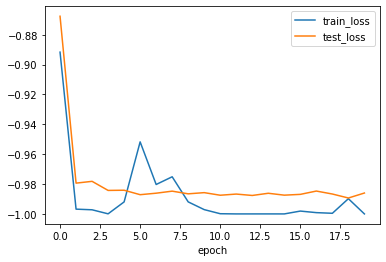

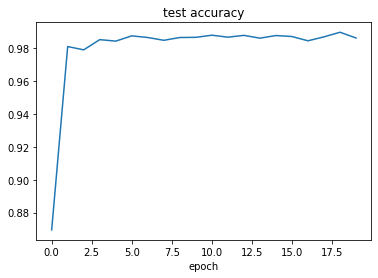

In [195]:
num_epoch
print(history)
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='train_loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('cnnloss.png')

plt.figure()
plt.plot(range(len(history['test_acc'])), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('cnn_test_acc2.png')